In [0]:
#RNN Model Eğitim Scripti
#v0.1 Google Colab Üzerinde çalışmaya hazır şekilde bir RNN Model Eğitimi Scripti
#    -csv ve txt şeklinde derlenmiş dataların işlenmesi destekleniyor.
#    -Google Colab platformunda teste hazır.
#    -Github'da bulunan örnek datalar kullanılabilir ve değerler üzerinde çalışılarak performans incelenebilir veya kullanıcılar 
#     crawler scriptini kullanarak oluşturduğu datayı kullanır.
#############################

#coding:utf8

# Kütüphanelerin içe aktarılması 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Google Colab ve Drive integrasyonu. Kullanıcılar kendi yerel bilgisayarlarında çalıştırmak için data path değişkenlerini değiştirmeli.
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/hackathon/preTrained.txt'


# Verinin giriş ve çıkış olarak ayrılması
dataframe = pd.read_csv(data_path, sep='|')
dataframe.Comment=dataframe.Comment.astype(str)
dataframe.Score=dataframe.Score.astype(float)

#train setinin örnek gösterimi
print('train set: {0}'.format(dataframe.shape))

x_train= dataframe['Comment']
y_train = dataframe['Score']

x_train.head(10)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
train set: (12602, 2)


0                            Çok iyi ürün ben begendim
1                                      Sorun yaşamadım
2                         dürüst satıcı özenli ambalaj
3                              mağaza iletişimi berbat
4                 yazılan mesajlara 2 gün sonra döndü.
5    11.11.2019 Tarihinde verdiğim sipariş 20.11.20...
6                             sürat kargoyu degistirin
7     Tavsiye ederim kargo ve paketleme cok özenlıydı.
8    Teşekkürler istediğim ürün özel paketleme hızl...
9        Teslimat ve mağaza konusunda sıkıntım olmadı.
Name: Comment, dtype: object

Burada olasılıklar histogram olarak gösterilmekte.

max phrase len: 593


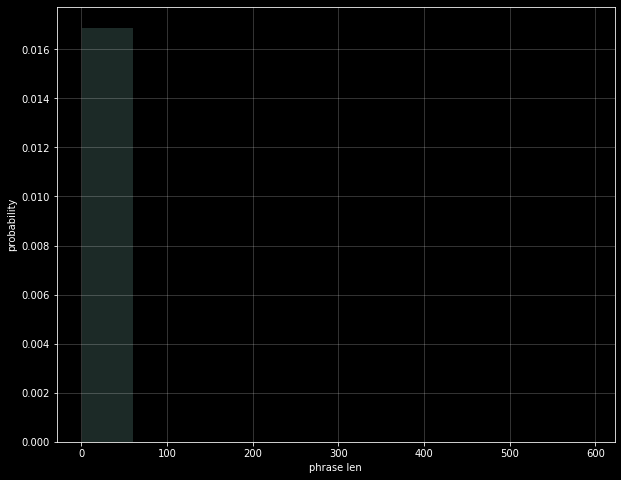

In [0]:
# Bu kısımda şu an için bir bug bulunmakta.
phrase_len = x_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [0]:
max_words = 8192
# Yapay sinir ağına verilecek girdide bulunan cümlelerinin tokenize edilmesi.
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen = max_phrase_len)



# Çıkış değerleri sistem tarafından değerlendirilebilmesi için OneHotEncoder formatına çevrilir
y_train = np.array(y_train)
label_encoder = LabelEncoder()
y_train_intencoded = label_encoder.fit_transform(y_train)
onehot_encoder = OneHotEncoder(sparse=False)
y_train_intencoded = y_train_intencoded.reshape(len(y_train_intencoded), 1)
y_train = onehot_encoder.fit_transform(y_train_intencoded)

#Çıkış değerlerinden bir kesit
print(y_train[0:4])



[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
#Model eğitimi için parametrelerin doldurulması.
batch_size = 256
epochs = 100

es = EarlyStopping(monitor='val_loss', mode='min',patience=3, verbose=1)
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.28))
model_lstm.add(LSTM(256, dropout = 0.28, recurrent_dropout = 0.28))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.28))
model_lstm.add(Dense(7, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

#Model eğitimi yapılması
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split = 0.25,
    epochs = 100,
    batch_size = 256,
    callbacks=[es]
)



Train on 9451 samples, validate on 3151 samples
Epoch 1/100
9451/9451 [==============================] - 79s 8ms/step - loss: 0.8793 - acc: 0.8172 - val_loss: 0.5351 - val_acc: 0.8772
Epoch 2/100
9451/9451 [==============================] - 75s 8ms/step - loss: 0.6533 - acc: 0.8259 - val_loss: 0.5059 - val_acc: 0.8772
Epoch 3/100
9451/9451 [==============================] - 71s 8ms/step - loss: 0.5686 - acc: 0.8377 - val_loss: 0.5041 - val_acc: 0.8718
Epoch 4/100
9451/9451 [==============================] - 70s 7ms/step - loss: 0.5108 - acc: 0.8521 - val_loss: 0.5294 - val_acc: 0.8680
Epoch 5/100
9451/9451 [==============================] - 69s 7ms/step - loss: 0.4640 - acc: 0.8620 - val_loss: 0.5584 - val_acc: 0.8692
Epoch 6/100
9451/9451 [==============================] - 70s 7ms/step - loss: 0.4311 - acc: 0.8710 - val_loss: 0.5894 - val_acc: 0.8670
Epoch 00006: early stopping


In [0]:
#Buraya tarihe gore dosya ismini degistirme uygulanabilir.
#Elde edilen modelin kaydedilmesi
model_lstm.save('/content/gdrive/My Drive/hackathon/RNN12kdataES.h5')

Grafikler kayıp ve ölçüm doğruluğunu göstermektedir.

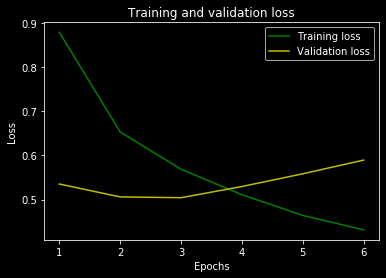

In [0]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

more plotting

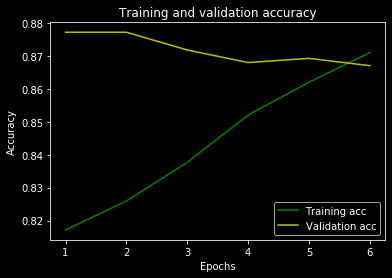

In [0]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Oluşturulan yeni modellerin test edilmesi için rastgele belirlenen tek değer üzerinden test yapılabilir.

test_comment = "İdare eder bir ürün kargo hızlı teşekkürler"
test_comment = tokenizer.texts_to_sequences([test_comment])
test_comment = pad_sequences(test_comment, 593)

test_output = model_lstm.predict([test_comment])
print(test_output)

result = [0,0,0,0,0,0,0]
result[np.argmax(test_output)]=1
print(result)








[0, 0, 0, 0, 0, 0, 1]
